# Solving CartPole problem using DeepSARSA
> 딥살사 알고리즘을 활용하여 카트폴 문제를 풀 수 있을까? Yes !

<video src="completed/deep_sarsa-500-episodes.mp4" controls></video>

In [1]:
import sys, os, math, random, copy, gym, pylab
import numpy as np
import matplotlib.pyplot as plt
from gym import envs
from IPython import display
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using TensorFlow backend.


/Users/psyoblade/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


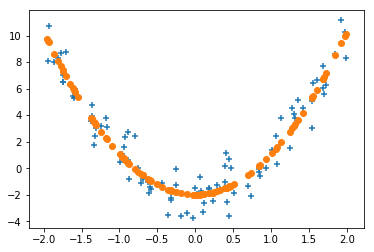

In [2]:
# 고정된 학습 네트워크 분포를 위해 시드를 고정
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(4523)

x = np.random.rand(100, 1) # 0 ~ 1 사이의 난수를 100개 생성
x = x * 4 - 2 # 값의 범위를 -2 ~ 2 사이로 변경
y = 3 * x**2 - 2 # y = a*x**2 + b*x+ c
y += np.random.randn(100, 1) # 평균이 0이고 표준편차가 1인 정규분포 

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x**2, y)

plt.scatter(x, y, marker='+')
plt.scatter(x, model.predict(x**2), marker='o')
plt.show()

In [3]:
# 매번 같은 숫자를 내어준다는 의미가 아니라, 시드 함수 호출 이후 항상 같은 랜덤 숫자를 반환합니다
# <a href="https://machinelearningmastery.com/reproducible-results-neural-networks-keras/">Reproducible_Keras_Vars</a>
random_seed = 4523
seed(random_seed)
expected=[0.32639907465349627, 0.2682238894755389, 0.7840440067765225]

class RandomNumber:
    def __init__(self, expected):
        self.expected = expected
    def assert_equals(self, i):
        actual = np.random.rand()
        expected = self.expected[i]
        assert(expected == actual)

randn = RandomNumber(expected)
for x in range(len(expected)):
    randn.assert_equals(x)
    
# 텐서 플로우의 경우에도 마찬가지로 시드 변수를 제공하면 동일한 효과를 가질 수 있습니다
from tensorflow import set_random_seed
import tensorflow as tf

set_random_seed(random_seed)

# 테스트 랜덤 시더
seednum = 1047104523

class RandomSeeder:
    global random_seed
    def __init__(self):
        self.set_seed()
        
    def set_seed(self, seed_number=seednum):
        seed(seed_number)
        set_random_seed(seed_number)
        
    def reset(self):
        seed()
        set_random_seed(0)
        
    def debug(self):
        x = np.random.rand()
        print(x)
    
seeder = RandomSeeder()
seeder.debug() # 0.6476178335731041
seeder.reset()
seeder.debug()
seeder.set_seed()
seeder.debug() # 0.6476178335731041
seeder.debug() # 0.17670961925684514

0.6476178335731041
0.9415636547329244
0.6476178335731041
0.17670961925684514


In [39]:
model_name='./models/deep_sarsa.h5'
image_name='./graphs/deep_sarsa.png'
cache_dir='./cartpole'

class DeepSARSAgent:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space.n
        self.observation_space = env.observation_space.shape[0]
        self.discount_factor = 0.999
        self.model = self.build_model()
        self.epsilon = 1.0
        self.epsilon_min = 0.01 # 학습 시에는 최소 10%는 랜덤 액션을 취하여 탐험을 추천한다
        self.epsilon_decay = 0.9999 # 1만 스텝에 70% 그리디 액션을 취한다
        self.act0 = 0
        self.act1 = 0

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(self.observation_space,), activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.action_space, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    def stdout(self, x):
#         sys.stdout.write(x)
        pass

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            self.act0 += 1
            return random.randrange(self.action_space)
        else:
            self.act1 += 1
            _state = np.reshape(state, [1, self.observation_space])
            q_values = self.model.predict(_state)
            return np.argmax(q_values[0])
        
    def get_greedy_action(self, state):
        _state = np.reshape(state, [1, self.observation_space])
        q_values = self.model.predict(_state)
        return np.argmax(q_values[0])
    
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        _state = np.reshape(state, [1, self.observation_space])
        target = self.model.predict(_state)[0]
        
        _next_state = np.reshape(next_state, [1, self.observation_space])
        if done:
            target[action] = reward * 0.1
        else:
            target[action] = (reward * 0.1 + self.discount_factor * self.model.predict(_next_state)[0][next_action])
        _target = np.reshape(target, [1, self.action_space])
        history = self.model.fit(_state, _target, epochs=1, verbose=0)
        loss = history.history['loss'][0]
        return loss
    
    def has_model(self, filename):
        return os.path.exists(filename)

    def save_weights(self, filename):
        self.model.save_weights(filename)
#         print("model saved '{}'".format(filename))

    def load_weights(self, filename):
        self.model.load_weights(filename)
#         print("model loaded '{}'".format(filename))
        
    def reset_weights(self, filename):
        if os.path.isfile(filename):
            os.remove(filename)
            
    def clear_cache_dir(self, dirname):
        if os.path.isdir(dirname):
            import shutil
            shutil.rmtree(dirname)

In [40]:
def test():
    env = gym.make('CartPole-v1')
    agent = DeepSARSAgent(env)
    if agent.has_model(model_name):
        agent.load_weights(model_name)
    agent.clear_cache_dir(cache_dir)
        
    wenv = gym.wrappers.Monitor(env, 'cartpole')
    t = 0
    done = False
    current_state = wenv.reset()
    while not done:
        wenv.render()
        t = t+1
        action = agent.get_greedy_action(current_state)
        obs, reward, done, _ = wenv.step(action)
        new_state = obs
        current_state = new_state
    return t
        
def learn(max_episodes, render, reset):
    env = gym.make('CartPole-v1')
    agent = DeepSARSAgent(env)
    if reset and agent.has_model(model_name):
        agent.reset_weights(model_name)
    if not reset and agent.has_model(model_name):
        agent.load_weights(model_name)
    global_score = 0
    episodes, scores, losses = [], [], []

    step = 0
    prev_score = 0
    curr_score = 0
    for e in range(max_episodes+1):
        if render:
            env.render()
        done = False
        score = 0
        total_loss = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_action = agent.get_action(next_state)
            loss = agent.train_model(state, action, reward, next_state, next_action, done)
#             state = next_state
            score += reward
            total_loss += loss
            step += 1
            state = copy.deepcopy(next_state)
            
            tmp_score = score
            if done:
                global_score += score
#                 episodes.append(e)
#                 scores.append(score)
#                 pylab.plot(episodes, scores, 'b')
#                 pylab.savefig(image_name)
                if e > 0 and e % 100 == 0:
#                     agent.tmodel.set_weights(agent.model.get_weights())
#                     print("score:%2.2f, total_loss:%2.2f" % (score, total_loss))
                    curr_score = tmp_score
                    gavg = math.ceil(global_score / e)
                    diff = curr_score - prev_score
                    ratio = math.ceil((agent.act1/(agent.act0 + agent.act1)) * 100.0)
                    print("[{}][{}%] g_avg:{}, \t g_score:{}, diff:{}, episode:{}".format(step, ratio, gavg, global_score, diff, e))
                    agent.save_weights(model_name)
                    prev_score = curr_score
    env.close()

In [41]:
seeder = RandomSeeder()
seeder.reset()
randint = random.randint(1, 99999) 
randint = 6071
print('result of seed ', randint)

seeder.set_seed(randint)
learn(500, False, True)
test()

result of seed  6071
[2384][11%] g_avg:24, 	 g_score:2384.0, diff:14.0, episode:100
[7475][30%] g_avg:38, 	 g_score:7475.0, diff:76.0, episode:200
[24428][63%] g_avg:82, 	 g_score:24428.0, diff:-76.0, episode:300
[50105][81%] g_avg:126, 	 g_score:50105.0, diff:156.0, episode:400
[66646][85%] g_avg:134, 	 g_score:66646.0, diff:20.0, episode:500


249

In [13]:
test()

model loaded './models/deep_sarsa.h5'


9

In [44]:
seeder = RandomSeeder()
seeder.reset()
randint = random.randint(1, 99999) 
randint = 6071
print('result of seed ', randint)

seeder.set_seed(randint)
learn(500, False, True)
test()

result of seed  6071
[2713][13%] g_avg:28, 	 g_score:2713.0, diff:23.0, episode:100
[8332][33%] g_avg:42, 	 g_score:8332.0, diff:173.0, episode:200
[28434][67%] g_avg:95, 	 g_score:28434.0, diff:149.0, episode:300
[69807][86%] g_avg:175, 	 g_score:69807.0, diff:155.0, episode:400
[105652][91%] g_avg:212, 	 g_score:105652.0, diff:-334.0, episode:500


500

In [45]:
# 9가 5개 설정은, 현재 설정은 1만에  90%, 10만 스텝에 약 60% 그리디 액션
epsilon=1.0
epsilon_decay=0.9999
for x in range(10000+1):
    epsilon *= epsilon_decay
    if x % 10000 == 0:
        print(x, epsilon)

0 0.9999
10000 0.3678242603283259


In [8]:
print(random.randint(1, 10))

7
